# Entrega 4 - Predictor de muerte de pacientes con HIV utilizando redes neuronales y regresión logistica

## 1. Objetivo

El objetivo principal de esta tarea es construir diferentes modelos de regresión logística y redes neuronales para predecir la muerte de pacientes bajo observación por HIV. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.

In [80]:
import importlib
import pandas as pd
import torch.optim as optim

# sklearn:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

In [82]:
import utilidades
import modelos
import entrenador

from modelos import *
from entrenador import *

importlib.reload(utilidades)
importlib.reload(entrenador)
importlib.reload(modelos)

<module 'modelos' from 'c:\\Users\\nicoa\\Desktop\\AA\\aprendizaje-automatico-2024\\4 - Redes Neuronales\\modelos.py'>

## 2. Diseño del predictor

 ### 2.1 Entrenamiento del predictor y evaluación.

Para realizar el entrenamiento, ajuste de la solución y evaluación del modelo, el conjunto de datos es separado en 3 particiones:

- Entrenamiento (80%): Utilizado para entrenar los diferentes modelos.
- Validación (10% del conjunto de entrenamiento): Para ajustar los valores de los hiperparametros
- Evaluación (20%): Para calcular las métricas de los modelos una vez entrenados.

Además, a la hora de separarlos, utilizamos el parámetro `stratify=Y` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $
- Pérdida del modelo

Estas métricas serán acompañadas con la visualización de la matriz de confusión correspondiente.

In [20]:
X = dataset.copy().drop(columns=[OBJETIVO, 'pidnum', 'time'])
Y = dataset[OBJETIVO].copy()

X_train_completo, X_test, Y_train_completo, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12345, stratify=Y)
X_train, X_validacion, Y_train, Y_validacion = train_test_split(X_train_completo, Y_train_completo, test_size=0.1, random_state=12345, stratify=Y_train_completo)

### 2.2 Preprocesamiento de los conjuntos de datos

Hablar del porque usamos preprocesamiento: Juan Jhon Scooby y standarizacion.

Notar que una vez entrenado el standarizador, se utiliza el mismo para transformar el conjunto de validacion y de test.

In [21]:
X_train = pd.get_dummies(X_train, columns=['trt', 'strat'], drop_first=False)
X_validacion = pd.get_dummies(X_validacion, columns=['trt', 'strat'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['trt', 'strat'], drop_first=False)
X_train_completo = pd.get_dummies(X_train_completo, columns=['trt', 'strat'], drop_first=False)

scaler_train_parcial = StandardScaler()
X_train = scaler_train_parcial.fit_transform(X_train)
X_validacion = scaler_train_parcial.transform(X_validacion)
X_test = scaler_train_parcial.transform(X_test)

# Genero un scaler para el train completo
# Para luego escalar los valores de X_test usando
# Este nuevo scaler
scaler_train_completo = StandardScaler()
X_train_completo = scaler_train_completo.fit_transform(X_train_completo)

# Se calcula el tamaño de las entradas
cant_caracteristicas = X_train.shape[1]

### 2.3 Configuración de libreria `Torch`

Al utilizar la librería PyTorch, es posible utilizar la tarjeta gráfica en caso de haber una compatible. En caso contrario, se utilizará el cpu. 

In [22]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(2024)

cpu


### 2.4 Linea base 

Se reutiliza la línea base del _Laboratorio 1_ (predictor que siempre devuelve 0), dado que se trabaja con el mismo conjunto. Se recuerda que la clase objetivo cuenta con 1618 entradas cuyo resultado es 0 y 521 cuyo resultado es 1. 

Los resultados reportados son los siguientes:

| Métrica           | Línea base     |
|-------------------|----------------|
| Accuracy          | 0.756          |
| Precision         | 0.756          |
| Recall            | 1.0            |
| F1 Score          | 0.861          |

### 2.5 Otras decisiones


## 3. Experimentación

### 3.1 Modelo 1: Regresión logisitca con scikit-learn

A continuación se genera un modelo de regresión logística, y se calcula su accuracy sobre el conjunto de validación.

In [23]:
modelo_1 = LogisticRegression()
modelo_1.fit(X_train, Y_train)

LogisticRegression()

Precisión del modelo: 0.78


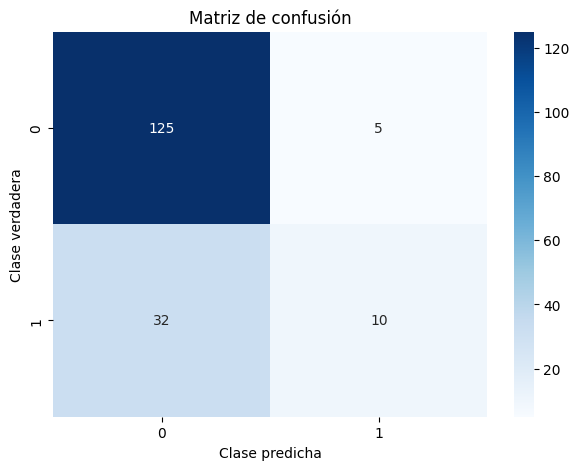

In [28]:
Y_pred = modelo_1.predict(X_validacion)

accuracy_modelo_1 = accuracy_score(Y_validacion, Y_pred)
print(f'Precisión del modelo: {accuracy_modelo_1:.2f}')

utilidades.plot_confusion_matrix(Y_validacion, Y_pred)

Se observa que el modelo tiene problemas para predecir la clase 1 (minoritaria), y está mas sesgado a predecir la clase 0.

### 3.2 Modelo 2: Red neuronal de una sola neurona sin función de activación

A continuación se crea un modelo compuesto por una sola capa lineal, con 2 salidas, sin función de activación.
Se toma como clase predicha cual salida es mayor.

In [55]:
# Creacion del modelo
modelo_2 = Modelo_2(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_2 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, dos_salidas=True, device=device)
data_loader_validacion_2 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, dos_salidas=True, device=device)

# Definición de la función de pérdida y el optimizador
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(modelo_2.parameters(), lr=0.0035)
entrenador_2 = Entrenador(modelo_2, data_loader_train_2, criterion_2, optimizer_2, dos_salidas=True)

perdida_train_evolucion_2 = []
perdida_validacion_evolucion_2 = []
accuracy_train_evolucion_2 = []
accuracy_validacion_evolucion_2 = []
epocas = 100

for epoca in range(epocas):
    entrenador_2.entrenar()

    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_2.evaluar_loss(data_loader_train_2)
    loss_validacion = entrenador_2.evaluar_loss(data_loader_validacion_2)
    perdida_train_evolucion_2.append(loss_train)
    perdida_validacion_evolucion_2.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_2.evaluar_accuracy(data_loader_train_2)
    accuracy_validacion = entrenador_2.evaluar_accuracy(data_loader_validacion_2)
    accuracy_train_evolucion_2.append(accuracy_train)
    accuracy_validacion_evolucion_2.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


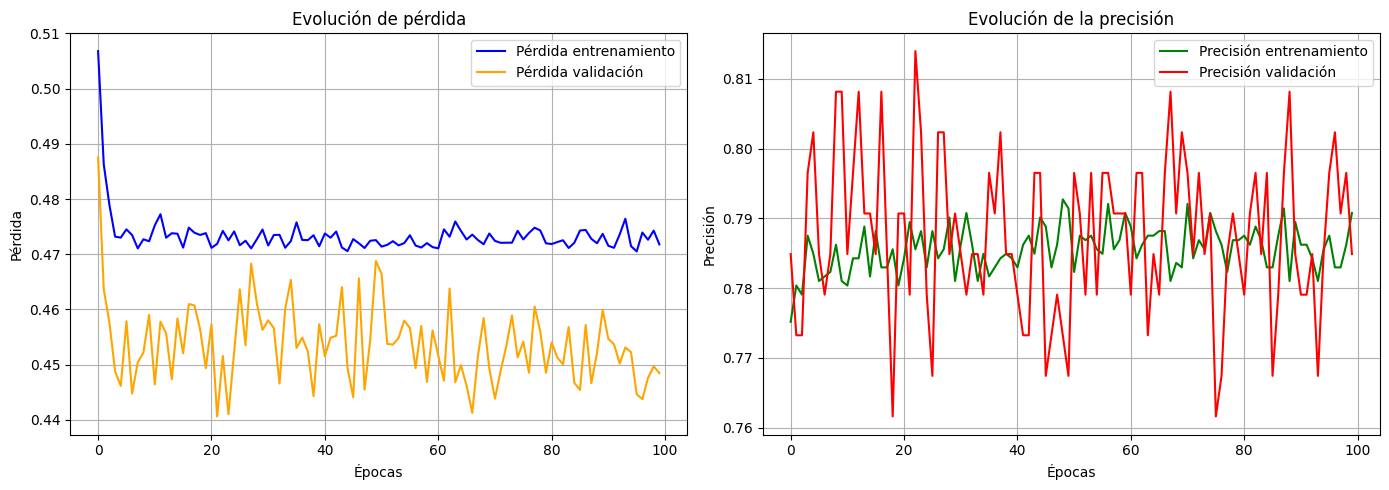

In [71]:
utilidades.graficar_metricas(perdida_train_evolucion_2, perdida_validacion_evolucion_2, accuracy_train_evolucion_2, accuracy_validacion_evolucion_2)

### 3.3 Modelo 3: Red neuronal de una sola neurona con función de activación

In [57]:
# Creacion del modelo
modelo_3 = Modelo_3(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_3 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, dos_salidas=False, device=device)
data_loader_validacion_3 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, dos_salidas=False, device=device)

# Definición de la función de pérdida y el optimizador
criterion_3 = nn.BCELoss()
optimizer_3 = optim.Adam(modelo_3.parameters(), lr=0.0035)
entrenador_3 = Entrenador(modelo_3, data_loader_train_3, criterion_3, optimizer_3, dos_salidas=False)

perdida_train_evolucion_3 = []
perdida_validacion_evolucion_3 = []
accuracy_train_evolucion_3 = []
accuracy_validacion_evolucion_3 = []
epocas = 100

for epoca in range(epocas):
    entrenador_3.entrenar()

    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_3.evaluar_loss(data_loader_train_3)
    loss_validacion = entrenador_3.evaluar_loss(data_loader_validacion_3)
    perdida_train_evolucion_3.append(loss_train)
    perdida_validacion_evolucion_3.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_3.evaluar_accuracy(data_loader_train_3)
    accuracy_validacion = entrenador_3.evaluar_accuracy(data_loader_validacion_3)
    accuracy_train_evolucion_3.append(accuracy_train)
    accuracy_validacion_evolucion_3.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


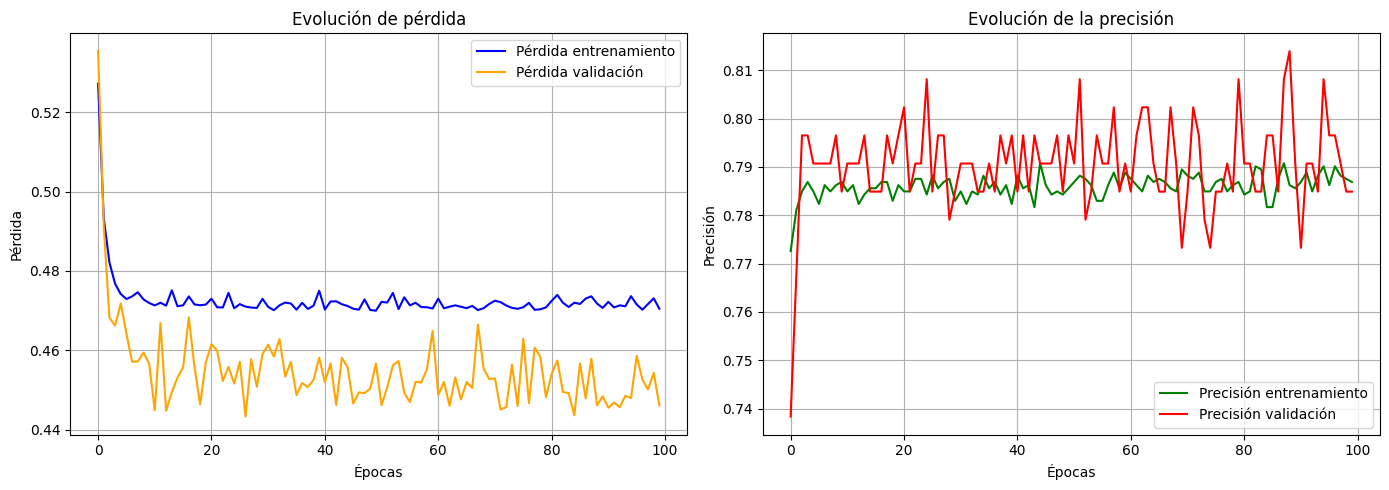

In [72]:
utilidades.graficar_metricas(perdida_train_evolucion_3, perdida_validacion_evolucion_3, accuracy_train_evolucion_3, accuracy_validacion_evolucion_3)

### 3.4 Modelo 4: Red neuronal con capas ocultas y función de activación

In [60]:
# Creacion del modelo
modelo_4 = Modelo_4(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_4 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion_4 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, device=device)

# Definición de la función de pérdida y el optimizador
criterion_4 = nn.BCELoss()
optimizer_4 = optim.Adam(modelo_4.parameters(), lr=0.0035)
entrenador_4 = Entrenador(modelo_4, data_loader_train_4, criterion_4, optimizer_4)

perdida_train_evolucion_4 = []
perdida_validacion_evolucion_4 = []
accuracy_train_evolucion_4 = []
accuracy_validacion_evolucion_4 = []
epocas = 100

for epoca in range(epocas):
    entrenador_4.entrenar()
    
    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_4.evaluar_loss(data_loader_train_4)
    loss_validacion = entrenador_4.evaluar_loss(data_loader_validacion_4)
    perdida_train_evolucion_4.append(loss_train)
    perdida_validacion_evolucion_4.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_4.evaluar_accuracy(data_loader_train_4)
    accuracy_validacion = entrenador_4.evaluar_accuracy(data_loader_validacion_4)
    accuracy_train_evolucion_4.append(accuracy_train)
    accuracy_validacion_evolucion_4.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada')

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


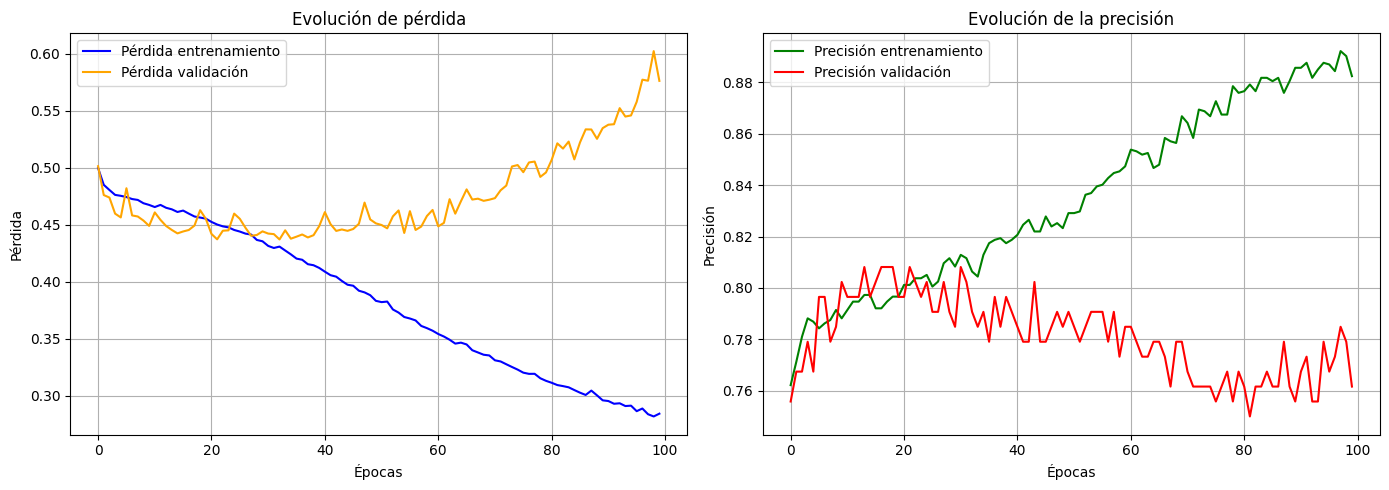

In [73]:
utilidades.graficar_metricas(perdida_train_evolucion_4, perdida_validacion_evolucion_4, accuracy_train_evolucion_4, accuracy_validacion_evolucion_4)

Se observa como el modelo es capaz de aprender a predecir dentro del conjunto de entrnamiento, alcanzando una precisión de casi el 90%, sin embargo, esto es debido a que el modelo esta sobreajustando a este conjunto, por lo que, luego de aproximadamente 20 epocas, la perdida dentro del conjunto de validación cmienza a aumentar, y la precisión a disminuir.

### 3.5 Modelo 5: Experimentación de arquitecturas

Se probarán 3 arquitecturas diferentes, variando la cantidad de unidades, capas ocultas y funciones de activación.
Para cada una, se probarán 5 valores diferentes para la tasa de aprendizaje.

In [64]:
tasas_de_aprendizaje = [0.0001, 0.001, 0.005, 0.01, 0.1]

#### 3.5.1: Modelo 1

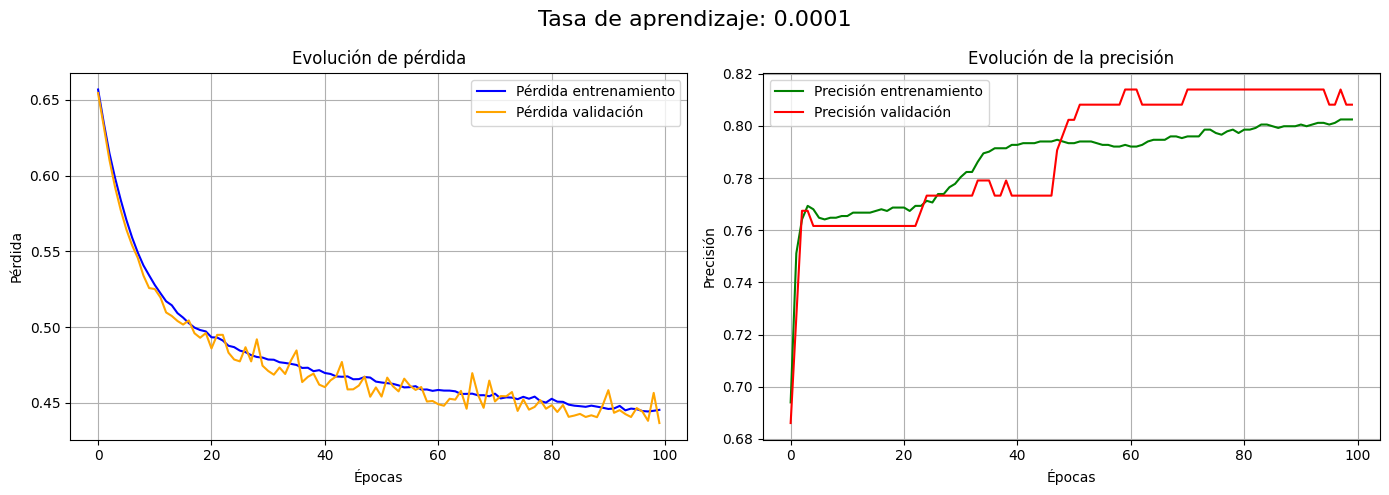

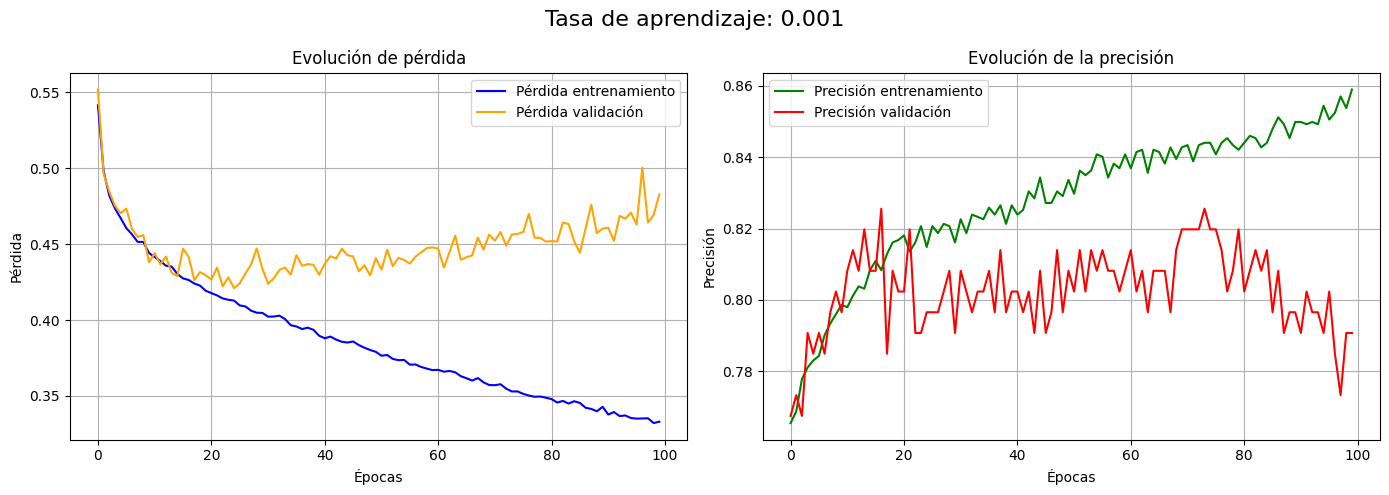

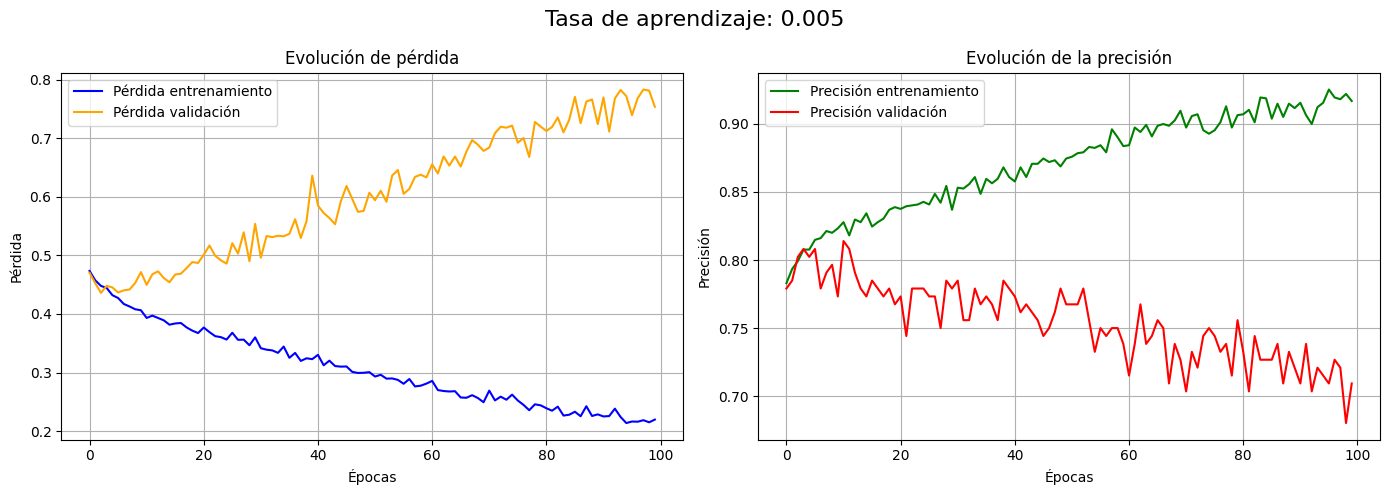

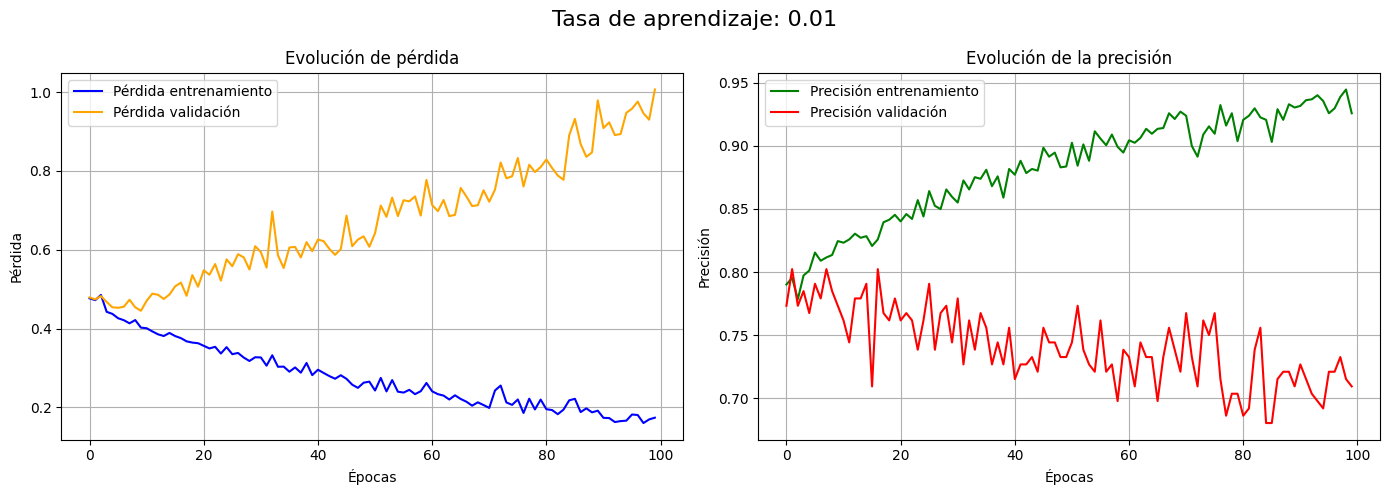

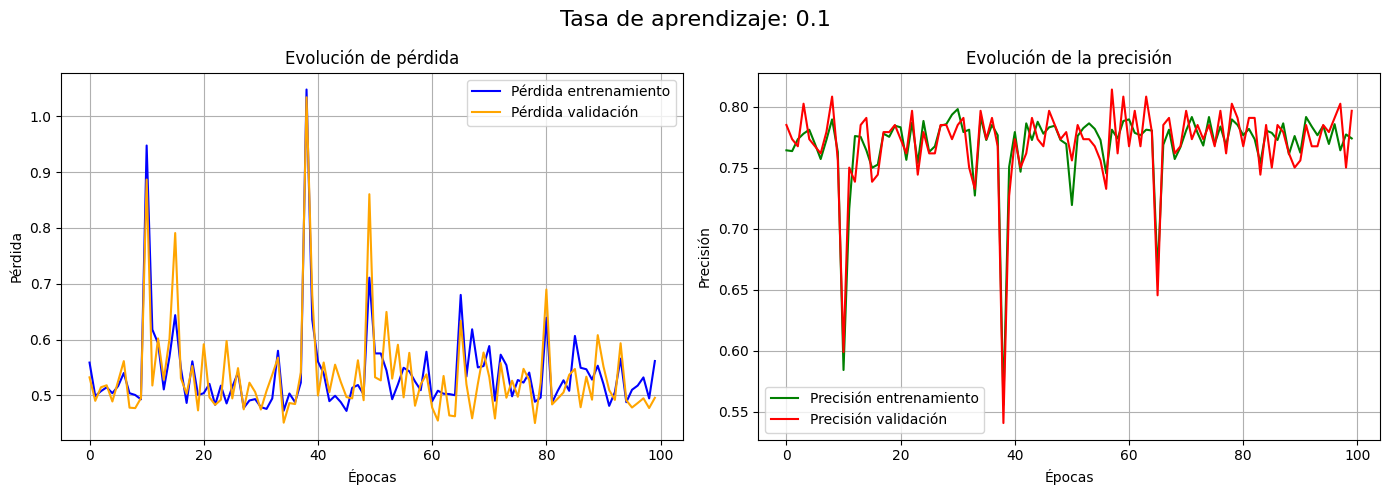

In [83]:
data_loader_train_5_1 = utilidades.crear_data_loader(X_train, Y_train, batch_size=16, device=device)
data_loader_validacion_5_1 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=16, device=device)

criterion_5_1 = nn.BCELoss()

for lr in tasas_de_aprendizaje:
    modelo_5_1 = Modelo_5_1(cant_caracteristicas).to(device) 

    optimizador_5_1 = torch.optim.Adam(modelo_5_1.parameters(), lr=lr, weight_decay=0.0001)
    entrenador_5_1 = Entrenador(modelo_5_1, data_loader_train_5_1, criterion_5_1, optimizador_5_1)

    perdida_train_evolucion_5_1 = []
    perdida_validacion_evolucion_5_1 = []
    accuracy_train_evolucion_5_1 = []
    accuracy_validacion_evolucion_5_1 = []
    epocas = 100

    for epoch in range(epocas):
        entrenador_5_1.entrenar()

        loss_train = entrenador_5_1.evaluar_loss(data_loader_train_4)
        loss_validacion = entrenador_5_1.evaluar_loss(data_loader_validacion_4)
        perdida_train_evolucion_5_1.append(loss_train)
        perdida_validacion_evolucion_5_1.append(loss_validacion)

        accuracy_train = entrenador_5_1.evaluar_accuracy(data_loader_train_4)
        accuracy_validacion = entrenador_5_1.evaluar_accuracy(data_loader_validacion_4)
        accuracy_train_evolucion_5_1.append(accuracy_train)
        accuracy_validacion_evolucion_5_1.append(accuracy_validacion)

    utilidades.graficar_metricas(perdida_train_evolucion_5_1, perdida_validacion_evolucion_5_1, accuracy_train_evolucion_5_1, accuracy_validacion_evolucion_5_1, lr)

#### 3.5.2: Modelo 2

#### 3.5.3: Modelo 3

## 4. Comparación

### 4.2 Resultados de la comparación

A continuación, se resumen todos los resultados obtenidos, incluyendo los de la tarea 1 y 2.


| Modelo            | Accuracy       | Precision | Recall | F1
|-------------------|----------------|-----------|--------|---
| ID3 Manual        | 0.8411         |           |        | 0.8952 
| ID3 Librería      | 0.8600         |           |        | 0.9000
| Random Forest     | 0.9000         |           |        | 0.9300
| Naive Bayes       | 0.8474         |           |        | 0.8981
| Modelo 1          |                |           |        |
| Modelo 2          |                |           |        |
| Modelo 3          |                |           |        |
| Modelo 4          |                |           |        |
| Modelo 5          |                |           |        |

## 5. Conclusiones

A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando árboles de decisión generados con el algoritmo ID3.

En particular, se prueban distintas configuraciones de hiper-parámetros y funciones de atributos. La combinación con mejor resultado fue utilizando la función `gain ratio`, con max_range_split de 3 y categorización _«in situ»_.

Las métricas de clasificación dieron una _accuracy_ de 0.84 y una puntuación f1 de 0.90 para la mejor configuración. Y este es competitivo con la implementación de Árboles de `scikit-learn` y, si bien el rendimiento es estrictamente inferior, es comparable con la implementación de Random Forest de la misma librería. 

Como mejoras a futuro podríamos listar:
- Explorar otros métodos de preprocesamiento de datos, como por ejemplo la selección de atributos en el dataset.
- Probar métodos más complejos como Random Forest.
- Aplicar técnicas para reducir el overfitting en caso de haberlo, como puede ser early stopping.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d290ba77-f85f-4658-8168-f585f89f4dfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>